In [48]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
  
from keras.layers import * 
from keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [49]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [50]:
  class Attention(tf.keras.layers.Layer):
    # implementing a layer that does attention according to Bahdanau style
    def __init__(self, units):
        super(Attention, self).__init__()
        # W1 weight of the previously hidden state(hidden_size x hidden_size)
        self.W1 = tf.keras.layers.Dense(units)
        # W2 weight for all the encoder hidden states
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # 'hidden' (h_t) is expanded over the time axis to prepare it for the addition 
        # that follows. hidden will always be the last hidden state of the RNN.
        # (in seq2seq in would have been the current state of the decoder step)
        # 'features' (h_s) are all the hidden states of the encoder.
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # Bahdanau additive style to compute the score:
        # score = v_a * tanh(W_1*h_t + W_2*h_s)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


#Build Network

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 400, 20)]    0                                            
__________________________________________________________________________________________________
permute_10 (Permute)            (None, 20, 400)      0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 10, 400)      610         permute_10[0][0]                 
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 10, 400)      1010        permute_10[0][0]                 
____________________________________________________________________________________________

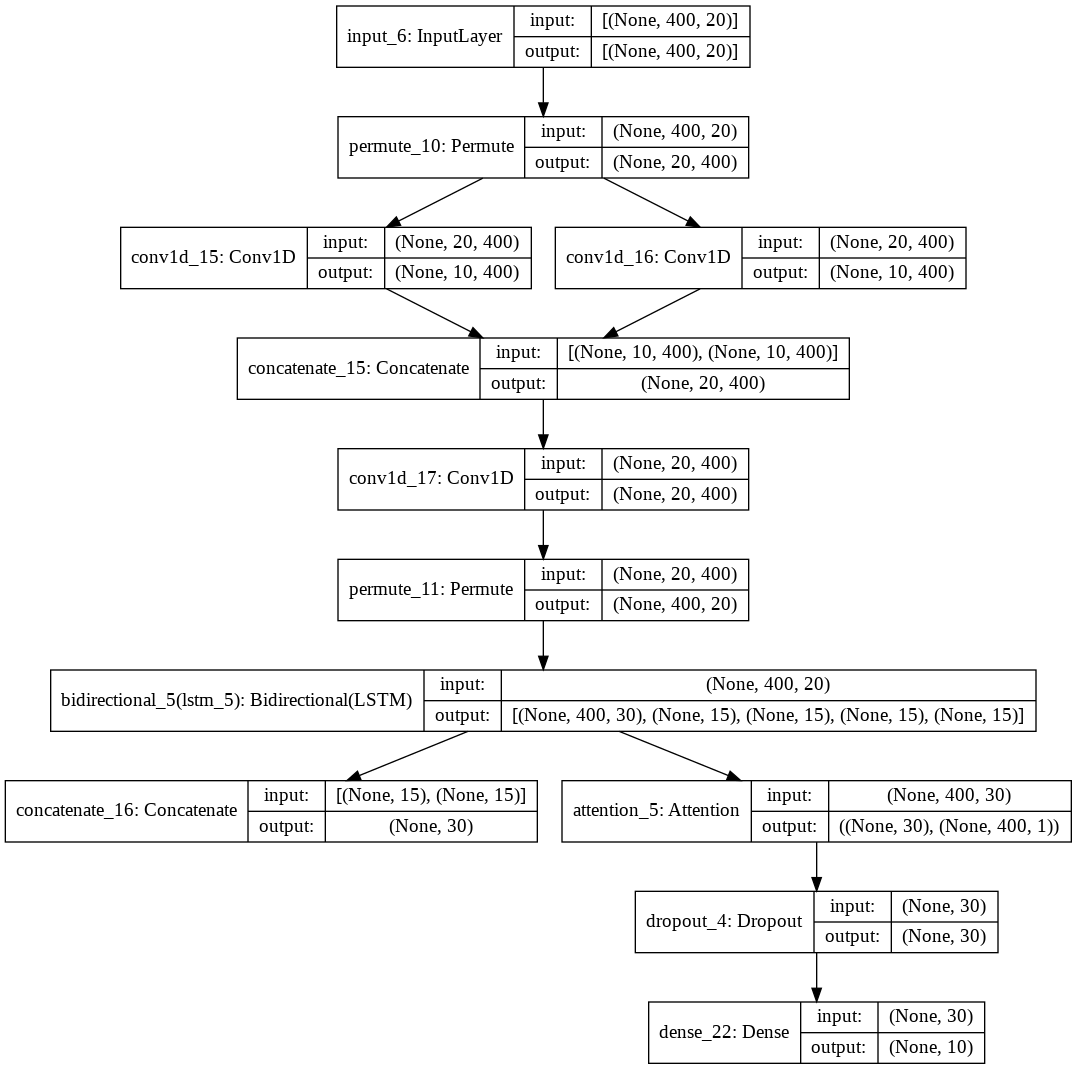

In [51]:
# Set hyperparameters

batch_size = 128
seq_len = 400
n_feat = 20
n_hid = 15
n_class = 10
lr = 0.0025
n_filt = 10
drop_prob = 0.5
num_epochs = 120

# Build model

inputs = keras.Input(shape=(seq_len, n_feat))

# mask to ignore the padded positions
l_mask = Masking(mask_value=0.0, input_shape=(None, n_feat))(inputs)

l_permute = layers.Permute((2,1))(inputs)

l_conv_a = layers.Conv1D(n_filt, 3, strides=1, padding="same", activation="relu", data_format='channels_first')(l_permute)
l_conv_b = layers.Conv1D(n_filt, 5, strides=1, padding="same", activation="relu", data_format='channels_first')(l_permute)
l_conc = tf.keras.layers.Concatenate(axis=1)([l_conv_a, l_conv_b])

l_conv_final = layers.Conv1D(n_filt*2, 3, strides=1, padding="same", activation="relu", data_format='channels_first')(l_conc)

l_reshu = layers.Permute((2, 1))(l_conv_final)

# encoders LSTM
l_lstm, forward_h, forward_c, backward_h, backward_c = layers.Bidirectional \
    (layers.LSTM
     (n_hid,
      dropout=0.2,
      return_sequences=True,
      return_state=True,
      activation="tanh"))(l_reshu)

state_h = layers.Concatenate()([forward_h, backward_h])
state_c = layers.Concatenate()([forward_c, backward_c])

# Set up the attention layer
context_vector, attention_weights = Attention(n_hid*2)(l_lstm, state_h)

l_drop = layers.Dropout(drop_prob)(context_vector)

l_out = layers.Dense(n_class, activation="softmax")(l_drop)

model = keras.Model(inputs, l_out)
model.summary()
keras.utils.plot_model(model, "model.png", show_shapes=True)


#Load datasets

In [52]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
_ = tf.compat.v1.Session(config=config)

# Load the encoded protein sequences, labels and masks
# The masks are not needed for the FFN or CNN models
train = np.load('/gdrive/My Drive/ProteinsML/Protein-subcellular-localization/data/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']
mask_train = train['mask_train']
#print(X_train.shape)
#print(X_train)

validation = np.load('/gdrive/My Drive/ProteinsML/Protein-subcellular-localization/data/reduced_val.npz')
X_val = validation['X_val']
y_val = validation['y_val']
mask_val = validation['mask_val']

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



#Train

In [53]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])
# todo weights normalization?
print(model.summary())
#plot_model(model, "model.png", show_shapes=True)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 400, 20)]    0                                            
__________________________________________________________________________________________________
permute_10 (Permute)            (None, 20, 400)      0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 10, 400)      610         permute_10[0][0]                 
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 10, 400)      1010        permute_10[0][0]                 
____________________________________________________________________________________________

In [54]:
y_train = to_categorical(y_train, n_class)
y_val = to_categorical(y_val, n_class)

checkpoint = ModelCheckpoint(filepath='/gdrive/My Drive/ProteinsML/Protein-subcellular-localization/weights/CCN-LSTM-Attention_weights.ckpt',
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            save_weights_only=True,
                            mode='min')

# Calculate also the prediction and network loss for the validation set:
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val), shuffle=True, callbacks=[checkpoint])


Epoch 1/120
19/19 [==============================] - 7s 117ms/step - loss: 2.2471 - accuracy: 0.1813 - val_loss: 2.0577 - val_accuracy: 0.2378

Epoch 00001: val_loss improved from inf to 2.05769, saving model to /gdrive/My Drive/ProteinsML/Protein-subcellular-localization/weights/CCN-LSTM-Attention_weights.ckpt
Epoch 2/120
19/19 [==============================] - 1s 56ms/step - loss: 2.0902 - accuracy: 0.2278 - val_loss: 1.9957 - val_accuracy: 0.3244

Epoch 00002: val_loss improved from 2.05769 to 1.99568, saving model to /gdrive/My Drive/ProteinsML/Protein-subcellular-localization/weights/CCN-LSTM-Attention_weights.ckpt
Epoch 3/120
19/19 [==============================] - 1s 57ms/step - loss: 1.9957 - accuracy: 0.2825 - val_loss: 2.1294 - val_accuracy: 0.2063

Epoch 00003: val_loss did not improve from 1.99568
Epoch 4/120
19/19 [==============================] - 1s 56ms/step - loss: 2.1054 - accuracy: 0.2627 - val_loss: 1.8728 - val_accuracy: 0.3843

Epoch 00004: val_loss improved fro

In [55]:
print("Minimum validation loss: {:.6f}".format(min(history.history['val_loss'])))
acc_index = np.argmin(history.history['val_loss'])
print("With accuracy: {:.6f}".format(history.history['val_accuracy'][acc_index]))

Minimum validation loss: 0.492024
With accuracy: 0.866142


## Plot

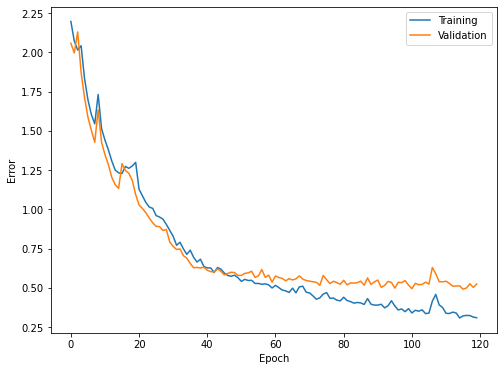

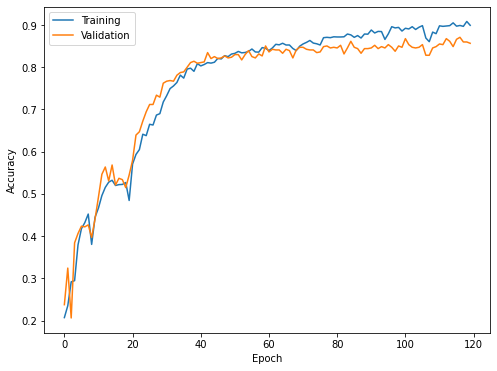

In [56]:
# Plots of loss and accuracy for training and validation set at each epoch
x_axis = range(num_epochs)
plt.figure(figsize=(8, 6))
# loss_training:
plt.plot(x_axis, history.history['loss'])
# loss_validation
plt.plot(x_axis, history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(('Training', 'Validation'))
plt.show()

plt.figure(figsize=(8, 6))
# accuracy training
plt.plot(x_axis, history.history['accuracy'])
# accuracy validation
plt.plot(x_axis, history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(('Training', 'Validation'))
plt.show()

### Confusion matrix
The confusion matrix shows how well is predicted each class and which are the most common mis-classifications.

Code based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


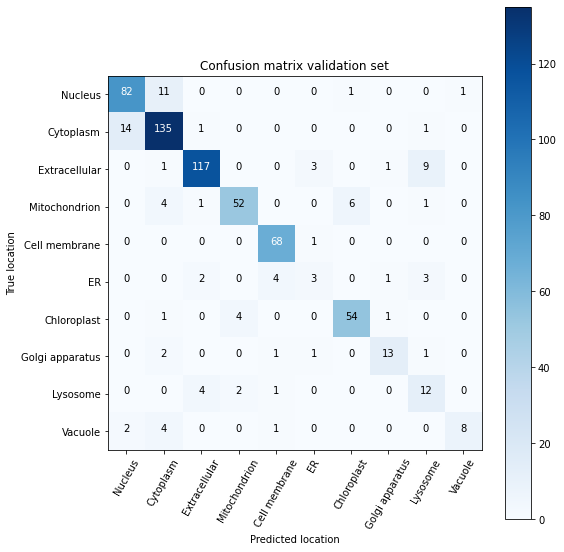

In [57]:
# todo compute confusion matrix using the model at the best epoch (saved checkpoint)
Y_pred = model.predict(X_val)
y_pred = np.argmax(Y_pred, axis=1)

confusion_mat = confusion_matrix(validation['y_val'], y_pred)

plt.figure(figsize=(8, 8))
colormap = plt.cm.Blues
plt.imshow(confusion_mat, interpolation='nearest', cmap=colormap)
plt.title('Confusion matrix validation set')
plt.colorbar()
tick_marks = np.arange(n_class)
classes = ['Nucleus', 'Cytoplasm', 'Extracellular', 'Mitochondrion', 'Cell membrane', 'ER', 'Chloroplast',
                'Golgi apparatus', 'Lysosome', 'Vacuole']

plt.xticks(tick_marks, classes, rotation=60)
plt.yticks(tick_marks, classes)

thresh = confusion_mat.max() / 2.
for i, j in itertools.product(range(confusion_mat.shape[0]), range(confusion_mat.shape[1])):
    plt.text(j, i, confusion_mat[i, j],
             horizontalalignment="center",
             color="white" if confusion_mat[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True location')
plt.xlabel('Predicted location')
plt.show()

### Sequence attention
We plot the attention values for the last validation batch. The attention differs between the subcellular localizations. The most clear examples are the extracellular proteins, where the attention is at the N-terminal, where the signal peptide is located.


In [58]:
# todo
